# Classification with supervised leanring - Sample code for homework 7

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter #計數器

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure()
    
    # plt.imshow(cm,cmap=plt.cm.get_cmap('gray', 1))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[y, x], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下：
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

In [0]:
from keras.utils import np_utils # 轉onehot
# DNN by keras
import keras.models 
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import Adam
from sklearn import preprocessing
from keras.layers import Dropout

# 建立Sequential模型
def build_model(in_layer=1000,hid_layer=500,out_layer=2):
    model = Sequential()
    model.add(Dense(input_dim=in_layer,units=hid_layer))
    model.add(Activation('relu'))
    model.add(Dense(units=out_layer))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    return model
# 建立Sequential模型
def build_model2(in_layer=1000,hid_layer1=500,hid_layer2=250,out_layer=2):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(in_layer,)))
    model.add(Dense(input_dim=in_layer,units=hid_layer1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2, input_shape=(hid_layer2,)))
    model.add(Activation('relu'))
    model.add(Dense(units=out_layer))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    return model
# 訓練繪圖工具
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

Using TensorFlow backend.


In [0]:
#Mount google drive to google colab virtual machine
from google.colab import drive
drive.mount('/content/drive')
mydrive ="/content/drive/My Drive/Colab Notebooks/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#download data from google drive
import gdown
url = "https://drive.google.com/uc?id=1jbb0HQ9oTZkRNK055AvXD3ya8_ZLtN9o"
gdown.download(url, mydrive+"Amazon_review.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1jbb0HQ9oTZkRNK055AvXD3ya8_ZLtN9o
To: /content/drive/My Drive/Colab Notebooks/Amazon_review.csv
4.52MB [00:00, 119MB/s]


'/content/drive/My Drive/Colab Notebooks/Amazon_review.csv'

In [0]:
#load dataset into pandas dataframe
import pandas as pd
amazon_reviewDF = pd.read_csv(mydrive+"Amazon_review.csv",delimiter=',',header = None)
amazon_reviewDF.columns=['text', 'label'] # name the column of dataframe 
amazon_reviewDF

,text,label
0,Stuning even for the non-gamer: This sound tra...,Positive
1,The best soundtrack ever to anything.: I'm rea...,Positive
2,Amazing!: This soundtrack is my favorite music...,Positive
3,Excellent Soundtrack: I truly like this soundt...,Positive
4,"Remember, Pull Your Jaw Off The Floor After He...",Positive
...,...,...
9995,A revelation of life in small town America in ...,Positive
9996,Great biography of a very interesting journali...,Positive
9997,Interesting Subject; Poor Presentation: You'd ...,Negative
9998,Don't buy: The box looked used and it is obvio...,Negative


In [0]:
amazon_reviewDF['text'][0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

Definition POS of spacy here: https://spacy.io/api/annotation#pos-tagging


In [0]:
# Define function for Lemmatization and feature selection using POS, spacy package
import spacy
def spacy_preprocess (text,lemma= True, pos= True, pos_select = ["VERB", "NOUN", "ADJ","ADV","PART"]):
  # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
  nlp = spacy.load('en', disable=['parser', 'ner']) # disable parser, ner for faster loading
  # Parse the sentence using the loaded 'en' model object `nlp`
  doc = nlp(text)
  if pos== False:
    if lemma== True: text_preprocess= " ".join([token.lemma_ for token in doc])
    if lemma== False:text_preprocess= " ".join([token.text for token in doc])
  else:
    if lemma== True : text_preprocess= " ".join([token.lemma_ for token in doc if token.pos_ in pos_select])
    if lemma== False : text_preprocess= " ".join([token.text for token in doc if token.pos_ in pos_select])
  return text_preprocess

In [0]:
from IPython.display import clear_output
#this may thake long time to process all 10.000 comments
amazon_reviewDF_lem_pos = amazon_reviewDF
for index in amazon_reviewDF.index:
   text =  amazon_reviewDF['text'][index]
   amazon_reviewDF_lem_pos['text'][index]= spacy_preprocess (text,lemma= True, pos= True, pos_select = ["VERB", "ADJ","ADV"])
   # print out the perentage complete
   clear_output(wait=True)
   if ((index+1)%10==0):print("finish %s" %(str(round((index+1)/100,2))+"%"))

# you should write the result after remove pos and lemmatizaiton to use later
amazon_reviewDF_lem_pos.to_csv(mydrive+"Amazon_review_lem_pos_vaa.csv", index = False)

finish 38.5%


**Now you have 2 data frame:**

the original one:  *amazon_reviewDF*

the data after lemmatization, pos: *amazon_reviewDF_lem_pos*

## max_features 500000

In [0]:
MAX_FEATURES = 500000

### Without POS

**Split Training - Testing data for validation**

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF['text'], 
                                                      amazon_reviewDF['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x) # compute tfidf for testing data set

Accuracy 0.72
F-score 0.714867617107943
confusion_matrix
 [[369 141]
 [139 351]]


<Figure size 432x288 with 0 Axes>

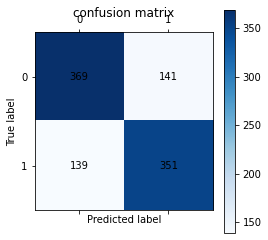

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.839
F-score 0.8338493292053664
confusion_matrix
 [[435  75]
 [ 86 404]]


<Figure size 432x288 with 0 Axes>

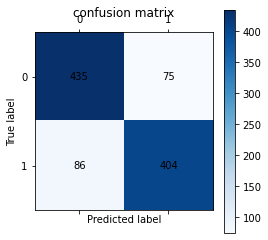

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en, valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.842
F-score 0.8381147540983608
confusion_matrix
 [[433  77]
 [ 81 409]]


<Figure size 432x288 with 0 Axes>

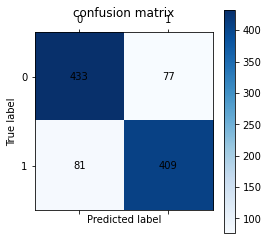

360.1977160000001


In [0]:
from sklearn.neural_network import MLPClassifier
import time
start = time.clock()
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en, valid_y_pred_nn)
end = time.clock()
print (end-start)

Accuracy 0.843
F-score 0.8418932527693858
confusion_matrix
 [[425  85]
 [ 72 418]]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<Figure size 432x288 with 0 Axes>

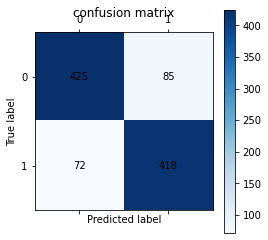

3547.357087


In [0]:
from sklearn.neural_network import MLPClassifier
import time
start = time.clock()

classifier_nn = MLPClassifier(hidden_layer_sizes=(500, 2),activation='logistic')
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en, valid_y_pred_nn)
end = time.clock()
print (end-start)

Accuracy 0.803
confusion_matrix
 [[414  96]
 [101 389]]


<Figure size 432x288 with 0 Axes>

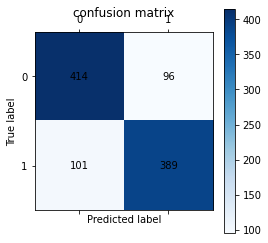

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier(max_depth=5)
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

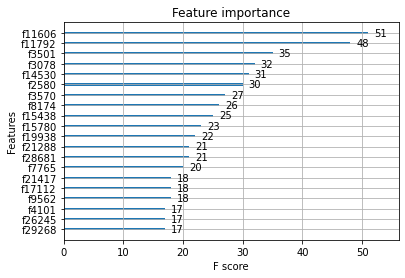

In [0]:
plot_importance(xgbc,max_num_features = 20)
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 29640)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               14820500  
_________________________________________________________________
activation_4 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1002      
_________________________________________________________________
activation_6 (Activation)    (None, 2)                

<Figure size 432x288 with 0 Axes>

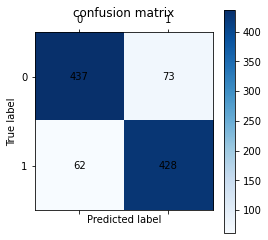

In [0]:
# User DNN
dnn = build_model2(in_layer=29640,hid_layer1=500,hid_layer2=500)
X_train,Y_train,X_test,Y_test = xtrain_tfidf,train_y_en,xvalid_tfidf,valid_y_en
Y_train_array = np.array(Y_train)
Y_train_onehot = np_utils.to_categorical(Y_train_array)
Y_test_array = np.array(Y_test)
Y_test_onehot = np_utils.to_categorical(Y_test_array)

train_history = dnn.fit(
    x=X_train,
    y=Y_train_onehot,
    validation_split=0.2,
    epochs=5,batch_size=500,verbose=2)

valid_y_pred_DNN = dnn.predict_classes(xvalid_tfidf)
accuracy_DNN = metrics.accuracy_score(valid_y_en, valid_y_pred_DNN)
confusion_matrix_DNN = metrics.confusion_matrix(valid_y_en, valid_y_pred_DNN, labels=[0,1])
print ("Accuracy", accuracy_DNN)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_DNN)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_DNN)
cm_plot(valid_y_en, valid_y_pred_DNN)

### With POS

In [0]:
amazon_reviewDF_lem_pos = pd.read_csv(mydrive+"Amazon_review_lem_pos_vaa.csv",delimiter=',',header = None)
amazon_reviewDF_lem_pos.columns=['text', 'label'] # name the column of dataframe
amazon_reviewDF_lem_pos=amazon_reviewDF_lem_pos.drop(labels=None,axis=0,index=0,inplace=False)
amazon_reviewDF_lem_pos

,text,label
1,stun even non - gamer sound beautiful paint so...,Positive
2,good ever read say good figure would write dis...,Positive
3,amazing favorite hand intense mean more play d...,Positive
4,excellent truly like enjoy play most here enjo...,Positive
5,remember pull hear play know how divine single...,Positive
...,...,...
9996,small early scholarly reveal much more small m...,Positive
9997,great very interesting small twentieth most fa...,Positive
9998,interesting poor would hard pressed tell borin...,Negative
9999,buy look used obviously new try contact buy,Negative


In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF_lem_pos['text'], 
                                                      amazon_reviewDF_lem_pos['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x.values.astype('U')) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x.values.astype('U')) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x.values.astype('U')) # compute tfidf for testing data set
# .values.astype('U') 是我把它改成unicode，因為不知道為甚麼他會跑error

Accuracy 0.692
F-score 0.6869918699186991
confusion_matrix
 [[354 156]
 [152 338]]


<Figure size 432x288 with 0 Axes>

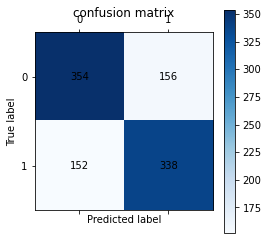

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.801
F-score 0.7937823834196892
confusion_matrix
 [[418  92]
 [107 383]]


<Figure size 432x288 with 0 Axes>

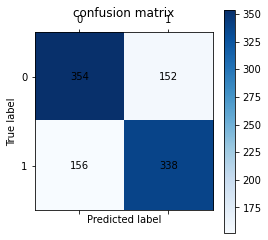

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.761
F-score 0.7553735926305015
confusion_matrix
 [[392 118]
 [121 369]]


<Figure size 432x288 with 0 Axes>

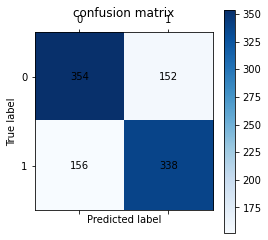

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_tree)

In [0]:
# neural network (user setting)

Accuracy 0.764
confusion_matrix
 [[416  94]
 [142 348]]


<Figure size 432x288 with 0 Axes>

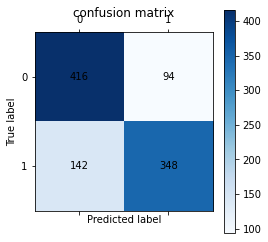

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier()
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

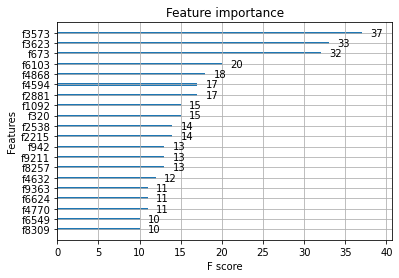

In [0]:
plot_importance(xgbc,max_num_features = 20)
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 9453)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               4727000   
_________________________________________________________________
activation_4 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1002      
_________________________________________________________________
activation_6 (Activation)    (None, 2)                

<Figure size 432x288 with 0 Axes>

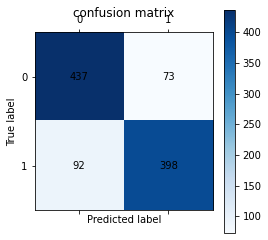

In [0]:
# User DNN
dnn = build_model2(in_layer=9453,hid_layer1=500,hid_layer2=500)
X_train,Y_train,X_test,Y_test = xtrain_tfidf,train_y_en,xvalid_tfidf,valid_y_en
Y_train_array = np.array(Y_train)
Y_train_onehot = np_utils.to_categorical(Y_train_array)
Y_test_array = np.array(Y_test)
Y_test_onehot = np_utils.to_categorical(Y_test_array)

train_history = dnn.fit(
    x=X_train,
    y=Y_train_onehot,
    validation_split=0.2,
    epochs=5,batch_size=500,verbose=2)

valid_y_pred_DNN = dnn.predict_classes(xvalid_tfidf)
accuracy_DNN = metrics.accuracy_score(valid_y_en, valid_y_pred_DNN)
confusion_matrix_DNN = metrics.confusion_matrix(valid_y_en, valid_y_pred_DNN, labels=[0,1])
print ("Accuracy", accuracy_DNN)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_DNN)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_DNN)
cm_plot(valid_y_en, valid_y_pred_DNN)

## max_features 50000

In [0]:
MAX_FEATURES = 50000

#### Without POS

**Split Training - Testing data for validation**

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF['text'], 
                                                      amazon_reviewDF['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x) # compute tfidf for testing data set

Accuracy 0.72
F-score 0.714867617107943
confusion_matrix
 [[369 141]
 [139 351]]


<Figure size 432x288 with 0 Axes>

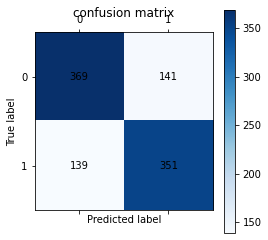

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.839
F-score 0.8338493292053664
confusion_matrix
 [[435  75]
 [ 86 404]]


<Figure size 432x288 with 0 Axes>

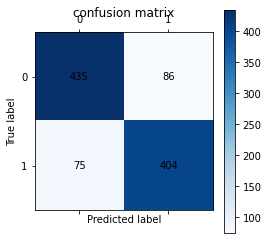

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.842
F-score 0.8381147540983608
confusion_matrix
 [[433  77]
 [ 81 409]]


<Figure size 432x288 with 0 Axes>

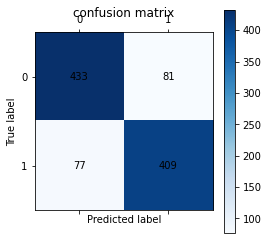

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_nn)

In [0]:
# neural network (user setting)

**Use XGBoost**

Accuracy 0.783
confusion_matrix
 [[420  90]
 [127 363]]


<Figure size 432x288 with 0 Axes>

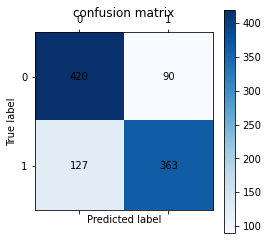

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier()
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

In [0]:
# User DNN
dnn = build_model2(29640,500,100,2)
X_train,Y_train,X_test,Y_test = xtrain_tfidf,train_y_en,xvalid_tfidf,valid_y_en
Y_train_array = np.array(Y_train)
Y_train_onehot = np_utils.to_categorical(Y_train_array)
Y_test_array = np.array(Y_test)
Y_test_onehot = np_utils.to_categorical(Y_test_array)

train_history = dnn.fit(
    x=X_train,
    y=Y_train_onehot,
    validation_split=0.2,
    epochs=10,batch_size=100,verbose=2)

valid_y_pred_DNN = dnn.predict_classes(xvalid_tfidf)
accuracy_DNN = metrics.accuracy_score(valid_y_en, valid_y_pred_DNN)
confusion_matrix_DNN = metrics.confusion_matrix(valid_y_en, valid_y_pred_DNN, labels=[0,1])
print ("Accuracy", accuracy_DNN)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_DNN)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_DNN)
cm_plot(valid_y_en, valid_y_pred_DNN)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          (None, 29640)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 500)               14820500  
_________________________________________________________________
activation_34 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               50100     
_________________________________________________________________
activation_35 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_36 (Activation)   (None, 2)               

#### With POS

In [0]:
amazon_reviewDF_lem_pos = pd.read_csv(mydrive+"Amazon_review_lem_pos_vaa.csv",delimiter=',',header = None)
amazon_reviewDF_lem_pos.columns=['text', 'label']

In [0]:
amazon_reviewDF_lem_pos['text'][1]

'stun even non - gamer sound beautiful paint so would recomend even hate play ever play good back away crude take soulful would impress care listen'

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF_lem_pos['text'], 
                                                      amazon_reviewDF_lem_pos['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x.astype('U')) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x.astype('U')) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x.astype('U')) # compute tfidf for testing data set

Accuracy 0.6973026973026973
F-score 0.686659772492244
confusion_matrix
 [[366 171]
 [132 332]]


<Figure size 432x288 with 0 Axes>

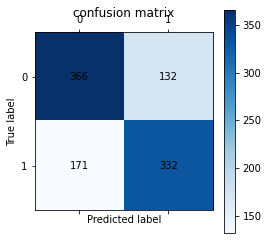

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.8071928071928072
F-score 0.7944621938232163
confusion_matrix
 [[435 102]
 [ 91 373]]


<Figure size 432x288 with 0 Axes>

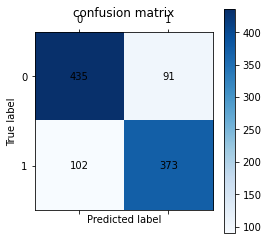

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.7802197802197802
F-score 0.7659574468085106
confusion_matrix
 [[421 116]
 [104 360]]


<Figure size 432x288 with 0 Axes>

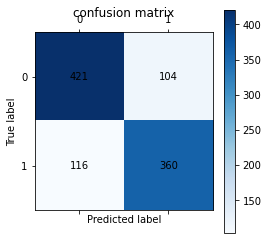

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_nn)

In [0]:
# neural network (user setting)

Accuracy 0.7542457542457542
confusion_matrix
 [[429 108]
 [138 326]]


<Figure size 432x288 with 0 Axes>

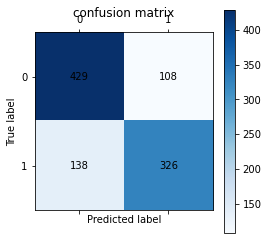

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier()
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

## MAX_FEATURES = 3000

In [0]:
MAX_FEATURES = 3000

#### Without POS

**Split Training - Testing data for validation**

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF['text'], 
                                                      amazon_reviewDF['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x) # compute tfidf for testing data set

Accuracy 0.702
F-score 0.6971544715447154
confusion_matrix
 [[359 151]
 [147 343]]


<Figure size 432x288 with 0 Axes>

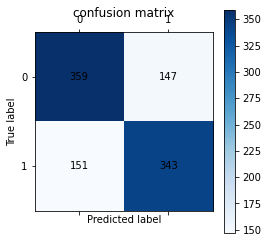

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.834
F-score 0.8333333333333334
confusion_matrix
 [[419  91]
 [ 75 415]]


<Figure size 432x288 with 0 Axes>

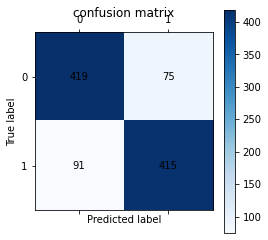

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.833
F-score 0.8304568527918782
confusion_matrix
 [[424  86]
 [ 81 409]]


<Figure size 432x288 with 0 Axes>

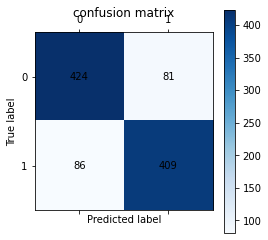

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_nn)

In [0]:
# neural network (user setting)

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier()
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

NameError: ignored

#### With POS

In [0]:
amazon_reviewDF_lem_pos = pd.read_csv(mydrive+"Amazon_review_lem_pos_vaa.csv",delimiter=',',header = None)
amazon_reviewDF_lem_pos.columns=['text', 'label']

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF_lem_pos['text'], 
                                                      amazon_reviewDF_lem_pos['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x.astype('U')) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x.astype('U')) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x.astype('U')) # compute tfidf for testing data set

Accuracy 0.7152847152847153
F-score 0.7058823529411765
confusion_matrix
 [[374 163]
 [122 342]]


<Figure size 432x288 with 0 Axes>

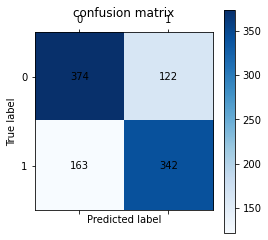

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.7972027972027972
F-score 0.788761706555671
confusion_matrix
 [[419 118]
 [ 85 379]]


<Figure size 432x288 with 0 Axes>

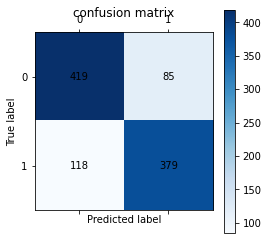

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.7752247752247752
F-score 0.7572815533980582
confusion_matrix
 [[425 112]
 [113 351]]


<Figure size 432x288 with 0 Axes>

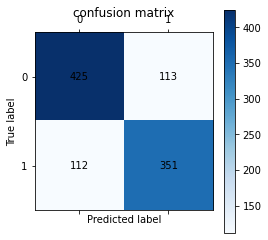

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_nn)

In [0]:
# neural network (user setting)

Accuracy 0.7522477522477522
confusion_matrix
 [[427 110]
 [138 326]]


<Figure size 432x288 with 0 Axes>

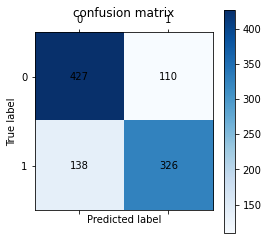

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier()
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

## MAX_FEATURES = 1000

In [0]:
MAX_FEATURES = 1000

#### Without POS

**Split Training - Testing data for validation**

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF['text'], 
                                                      amazon_reviewDF['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x) # compute tfidf for testing data set

Accuracy 0.706
F-score 0.7036290322580645
confusion_matrix
 [[357 153]
 [141 349]]


<Figure size 432x288 with 0 Axes>

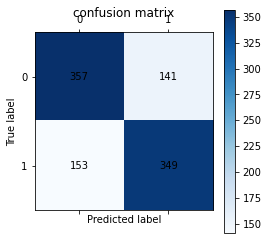

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.821
F-score 0.8204613841524574
confusion_matrix
 [[412  98]
 [ 81 409]]


<Figure size 432x288 with 0 Axes>

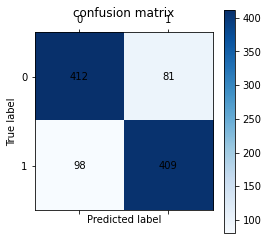

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.823
F-score 0.8199389623601221
confusion_matrix
 [[420  90]
 [ 87 403]]


<Figure size 432x288 with 0 Axes>

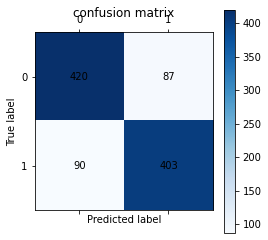

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_nn)

In [0]:
# neural network (user setting)

Accuracy 0.801
F-score 0.7946336429308565
confusion_matrix
 [[416  94]
 [105 385]]


<Figure size 432x288 with 0 Axes>

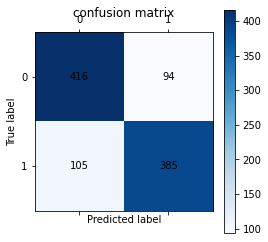

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier(max_depth=5)
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 500)               500500    
_________________________________________________________________
activation_28 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               50100     
_________________________________________________________________
activation_29 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_30 (Activation)   (None, 2)               

<Figure size 432x288 with 0 Axes>

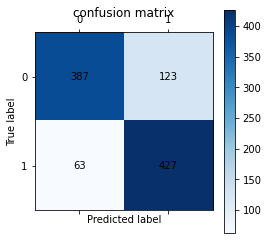

In [0]:
dnn = build_model2(MAX_FEATURES,500,100,2)
X_train,Y_train,X_test,Y_test = xtrain_tfidf,train_y_en,xvalid_tfidf,valid_y_en
Y_train_array = np.array(Y_train)
Y_train_onehot = np_utils.to_categorical(Y_train_array)
Y_test_array = np.array(Y_test)
Y_test_onehot = np_utils.to_categorical(Y_test_array)

train_history = dnn.fit(
    x=X_train,
    y=Y_train_onehot,
    validation_split=0.2,
    epochs=10,batch_size=100,verbose=2)

valid_y_pred_DNN = dnn.predict_classes(xvalid_tfidf)
accuracy_DNN = metrics.accuracy_score(valid_y_en, valid_y_pred_DNN)
confusion_matrix_DNN = metrics.confusion_matrix(valid_y_en, valid_y_pred_DNN, labels=[0,1])
print ("Accuracy", accuracy_DNN)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_DNN)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_DNN)
cm_plot(valid_y_en, valid_y_pred_DNN)

#### With POS

In [0]:
amazon_reviewDF_lem_pos = pd.read_csv(mydrive+"Amazon_review_lem_pos_vaa.csv",delimiter=',',header = None)
amazon_reviewDF_lem_pos.columns=['text', 'label']

In [0]:
from sklearn import model_selection

# split the dataset into training and testing 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(amazon_reviewDF_lem_pos['text'], 
                                                      amazon_reviewDF_lem_pos['label'],test_size=0.1,random_state=1)

#test_size = 0.1 mean 90% data is used for traning data, 10% for testing data.


from sklearn import preprocessing
# encode the target variable, label Negative/Positive -> 0/1
encoder = preprocessing.LabelEncoder()
train_y_en = encoder.fit_transform(train_y)
valid_y_en = encoder.fit_transform(valid_y)

from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = MAX_FEATURES)
tfidf_vect.fit(train_x.astype('U')) #Learn vocabulary and idf from training data set. (in bad words)
xtrain_tfidf =  tfidf_vect.transform(train_x.astype('U')) # compute tfidf for tranning data set
xvalid_tfidf =  tfidf_vect.transform(valid_x.astype('U')) # compute tfidf for testing data set

Accuracy 0.7092907092907093
F-score 0.6965589155370177
confusion_matrix
 [[376 161]
 [130 334]]


<Figure size 432x288 with 0 Axes>

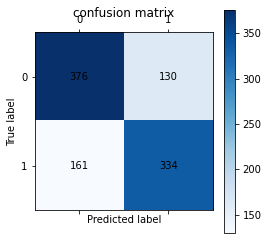

In [0]:
from sklearn import tree,  metrics
classifier_tree = tree.DecisionTreeClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_tree =classifier_tree.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_tree = classifier_tree.predict(xvalid_tfidf)
accuracy_tree = metrics.accuracy_score(valid_y_en, valid_y_pred_tree)
confusion_matrix_tree = metrics.confusion_matrix(valid_y_en, valid_y_pred_tree, labels=[0,1])
print ("Accuracy", accuracy_tree)
F1_score1=metrics.f1_score(valid_y_en, valid_y_pred_tree)
print ("F-score", F1_score1)
print ("confusion_matrix\n", confusion_matrix_tree)
cm_plot(valid_y_en,valid_y_pred_tree)

**Use RandomForestClassifier- Full code**

Accuracy 0.7872127872127872
F-score 0.7778936392075078
confusion_matrix
 [[415 122]
 [ 91 373]]


<Figure size 432x288 with 0 Axes>

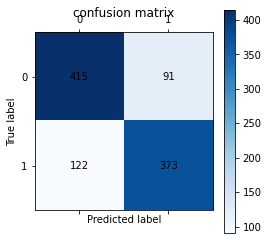

In [0]:
from sklearn import ensemble
classifier_rf = ensemble.RandomForestClassifier(random_state= 1)
# fit the training dataset on the classifier
classifier_rf.fit(xtrain_tfidf, train_y_en)

# predict the labels on validation dataset
valid_y_pred_rf = classifier_rf.predict(xvalid_tfidf)

accuracy_rf = metrics.accuracy_score(valid_y_en, valid_y_pred_rf)
confusion_matrix_rf = metrics.confusion_matrix(valid_y_en, valid_y_pred_rf, labels=[0,1])
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_rf)
print ("Accuracy", accuracy_rf)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_rf)
cm_plot(valid_y_en,valid_y_pred_rf)

**Use Neural Network- Multi-layer Perceptron classifier.**

Accuracy 0.7972027972027972
F-score 0.78609062170706
confusion_matrix
 [[425 112]
 [ 91 373]]


<Figure size 432x288 with 0 Axes>

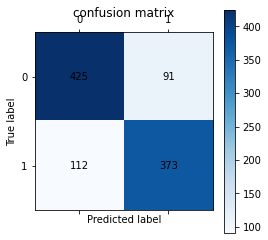

In [0]:
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier(random_state=1)
# fit the training dataset on the classifier
classifier_nn.fit(xtrain_tfidf, train_y_en) # take around 3-4 minutes

# predict the labels on validation dataset
valid_y_pred_nn = classifier_nn.predict(xvalid_tfidf)

accuracy_nn = metrics.accuracy_score(valid_y_en, valid_y_pred_nn)
confusion_matrix_nn = metrics.confusion_matrix(valid_y_en, valid_y_pred_nn, labels=[0,1])
print ("Accuracy", accuracy_nn)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_nn)
print ("F-score", F1_score)
print ("confusion_matrix\n", confusion_matrix_nn)
cm_plot(valid_y_en,valid_y_pred_nn)

In [0]:
# neural network (user setting)

Accuracy 0.801
confusion_matrix
 [[416  94]
 [105 385]]


<Figure size 432x288 with 0 Axes>

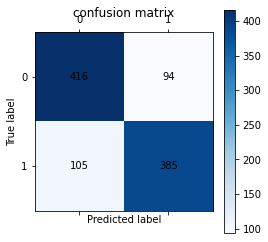

In [0]:
# XGBoost
from xgboost import XGBClassifier # XGB 分類器
from xgboost import plot_importance # XGB特徵重要性

xgbc = XGBClassifier(max_depth=5)
# fit the training dataset on the classifier
xgbc.fit(xtrain_tfidf,train_y_en)
# predict the labels on validation dataset
valid_y_pred_xgbc = xgbc.predict(xvalid_tfidf)

accuracy_xgb = metrics.accuracy_score(valid_y_en, valid_y_pred_xgbc)
confusion_matrix_xgb = metrics.confusion_matrix(valid_y_en, valid_y_pred_xgbc, labels=[0,1])
print ("Accuracy", accuracy_xgb)
F1_score=metrics.f1_score(valid_y_en, valid_y_pred_xgbc)
print ("confusion_matrix\n", confusion_matrix_xgb)
cm_plot(valid_y_en, valid_y_pred_xgbc)

# Assignment 7 

## Result
### test 1

|                     | without POS                 | POS                                   |
| ------------------- |:--------------------------- |:------------------------------------- |
| classification tree | **0.72, 0.7149** | 0.6973, 0.6867 |

### test 2
Compare the classification tree method with different limit of max features without POS tagging.

| max_feature |     without POS      |
| -----------:|:--------------------:|
|      500000 | **0.72,  0.7149** |
|        5000 |   0.716, 0.7232   |
|        3000 |   0.702, 0.6972   |
|        1000 |   0.706, 0.7036   |

### test 3
| model                                        | without POS, max_feature = 500000 |
| -------------------------------------------- |:---------------------------------:|
| classification tree                          |           0.72, 0.7149            |
| random forest                                |           0.839, 0.8338           |
| neural network (default setting)             |         **0.842, 0.8381**         |
| neural network (hidden_layer_sizes=(500, 2)) |           0.838, 0.8350           |

### (optional) other classification algorithms
| model   | without POS, max_feature = MAX |
|:------- |:------------------------------:|
| XGBoost |         0.803, 0.7979          |
| DNN     |       **0.865, 0.8637**        |

+ DNN
    + model imfomation ![](https://i.imgur.com/on2gxfK.png)
    + add Dropout layer
    + no too deep (2 hidden layers)
+ XGBoost
    + We compare the importance of the features with and without POS and both  not setting the limitations on max features, and then we sort the most important twenty features.
    + **Without POS：**
    ![](https://i.imgur.com/CKM8V1B.png)
    + **With POS：**
    ![](https://i.imgur.com/D1yOF6c.png)
    + In the comparison of the two pictures, we found that in the without-POS model, the features with greater importance have higher F-score than those in the POS model. That means the words we’ve deleted in the POS tagging process is useful for us to achieve our target, which is to predict whether it is positive or not.





## Discuss and answer the question
###  requirement :
- pdf file (1-2 pages, show your comparison)
- What can you conclude after performing tests 1, 2, 3? Please suggest the best model from the your team perspective.
### comparison :
- **Test 1: Lemmatization & POS v.s No Lemmatization & POS**
We found that in the classification tree, data **without POS tagging** and lemmatization gives better result, and its accuracy is higher than that with POS tagging and lemmatization.
- **Test 2: Max features(500000,5000,3000,1000)**
We choose the data without POS tagging and lemmatization, and then try four different number of max feature(500000,5000,3000,1000) to train the data.
Finally, we find that **the largest features(500000)** gives best output.
- **Test 3: random forest ; classification tree ; neural network (default setting) ; neural network (user setting)**
After testing different classification algorithm, we found that neural network (default setting) gives the best output, the accuracy is 0.842, and the F-score is 0.8381147540983608, and this process costs about 360 seconds to finish. 


- **Conclusion**  
　　By concluding the test 1,2,3 in our model, we found that using neual network to classify by setting max feature=500000 without POS tagging will give us the best accuracy and F-score. We come up with some possible and reasonable explanations of this outcome. 
　　First of all, the reason why **without POS tagging gives better outcome** might be that it keeps more  words, which **gives our model more features to select and analyze**, and we get higher accuracy. Besides, the amount of data is big enough; therefore, we can use max feature=500000 to analyze. Then by the testing, neural network with defualt setting has the highest accuracy, we consider that it's because its training way is more complicated and more accrate. Whereas, it also take the longest time to run, which is about 360 seconds, and if we **change its layers and activation algorithm together**, it will spend **over 3500 seconds** to finish; thus, if we are in hurry, the best choice would be the random forest. Moreover, we use two more classification algorithms(XGboost and DNN using keras) to analyze the data, which improve the accuracy up to 0.865.  
　　The reason why we set a limit of max features is to prevent **curse of dimensionality**, which refers to the performance of classifier is the highest with specific dimensions. When we have fewer amount of feature limits, the data with POS tagging won’t have much change on its forecast ability toward the so-called general cases. The data without POS tagging originally have better predicting ability toward different special cases for it has more features as references, while when we have limitations on the amount of features, the left features for those special case have weaker abilities in predicting the general cases; thus the overall accuracy and F-score decrease. So that the smaller number of features can better analyze the data than the larger number of the features, which indicates that the curse of dimensionality does not happened with sufficient data in this case.  
![](https://i.imgur.com/RGWctlu.png)    
　　In conclusion, whether the text with POS tagging  and how to set the feature amount to get the best accuracy depends on the amount and attributes of original data. In the case of this homework, we have large amount of data; thus it is better to use more features without POS tagging to train our data. 

